In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#input parameters
epsilons=[0, .05, .1, .15, .2, .25, .3]
pretrained_model='data/lenet_mnist_model.pth'
use_cuda=True

#LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)
#MNIST dataset and dataloader declaration
test_loader=torch.utils.data.DataLoader(datasets.MNIST('mnist',train=False,download=True,
                                                       transform=transforms.Compose([transforms.ToTensor()])),
                                       batch_size=1,shuffle=True)
#Define what device we are using
print('CUDA Available:',torch.cuda.is_available())
device=torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
#initialize the network
model=Net().to(device)
#load the pretrained model
model.load_state_dict(torch.load(pretrained_model,map_location='cpu'))
#set the model in evaluation mode
model.eval()

CUDA Available: True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
#FGSA function
def fsgm_attack(image,epsilon,data_grad):
    #Collect the element-wise sign of the data gradient
    sign_data_grad=data_grad.sign()
    #调整输入图像的每个像素值创造干扰图像
    perturbed_image=image+epsilon*sign_data_grad
    #将输入图像的像素值修改为[0,1]范围内
    perturbed_image=torch.clamp(perturbed_image,0,1)
    return perturbed_image

#Test function
def test(model,device,test_loader,epsilon):
    correct=0   #Accuracu counter
    adv_examples=[]
    #Loop over all examples in the testset
    for data,target in test_loader:
        #Send data and label to device
        data,target=data.to(device),target.to(device)
        #Set requires_grad attribute,which is important to attack
        data.requires_grad=True
        #Forward the data through model，得到预测类别
        output=model(data)
        init_pred=output.max(1,keepdim=True)[1]
        #如果预测错误，不影响attack
        if init_pred.item()!=target.item():
            continue
        loss=F.nll_loss(output,target)
        model.zero_grad()
        loss.backward()
        data_grad=data.grad.data   #得到模型对输入图片的梯度
        #生成干扰数据
        perturbed_data=fsgm_attack(data,epsilon,data_grad)
        #forward perturbed image through model
        output=model(perturbed_data)
        final_pred=output.max(1,keepdim=True)[1]
        if final_pred.item()==target.item():
            correct+=1
            #保存5张没有攻击的图片
            if (epsilon==0) and (len(adv_examples)<5):
                adv_ex=perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
        else:   #成功攻击
            if len(adv_examples)<5:
                adv_ex=perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
    #计算epsilon取值时的accuracy
    final_acc=correct/float(len(test_loader))
    print('Epsilon:{}\t Accuracy={}/{}={}'.format(epsilon,correct,len(test_loader),final_acc))
    return final_acc,adv_examples

In [11]:
#run attack
accuracies=[]
examples=[]
#run test for each epsilon
for eps in epsilons:
    acc,adv=test(model,device,test_loader,eps)
    accuracies.append(acc)
    examples.append(adv)

Epsilon:0	 Accuracy=9810/10000=0.981
Epsilon:0.05	 Accuracy=9426/10000=0.9426
Epsilon:0.1	 Accuracy=8510/10000=0.851
Epsilon:0.15	 Accuracy=6826/10000=0.6826
Epsilon:0.2	 Accuracy=4301/10000=0.4301
Epsilon:0.25	 Accuracy=2082/10000=0.2082
Epsilon:0.3	 Accuracy=869/10000=0.0869


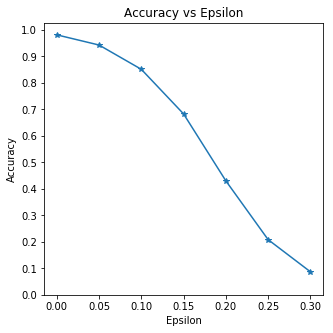

In [12]:
#Visual Accuracy VS epsilon
plt.figure(figsize=(5,5))
plt.plot(epsilons,accuracies,'*-')
plt.yticks(np.arange(0,1.1,step=0.1))
plt.xticks(np.arange(0,.35,step=.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

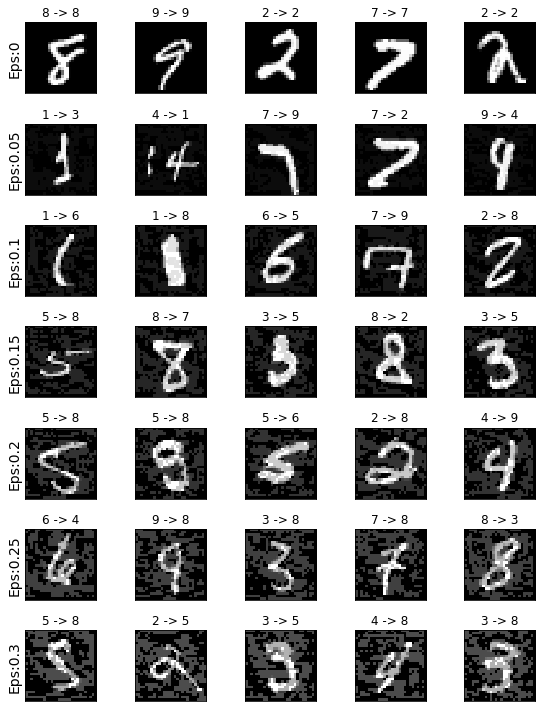

In [14]:
#Plot several examples of adversial samples at each epsilon
cnt=0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt+=1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([],[])
        plt.yticks([],[])
        if j==0:
            plt.ylabel('Eps:{}'.format(epsilons[i]),fontsize=14)
        orig,adv,ex=examples[i][j]
        plt.title('{} -> {}'.format(orig,adv))
        plt.imshow(ex,cmap='gray')
plt.tight_layout()
plt.show()